In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import json
import os

In [ ]:
dataset = []
with open('data/clusters/bias_dataset_bfcl_format.jsonl') as f:
    data = [json.loads(line) for line in f]
print(data[0]['function'])

[{'name': 'goapis_geocoding_api.geocding', 'description': "Geocoding is the process of converting a physical address into geographic coordinates, such as latitude and longitude. It allows for the identification of a specific location on the Earth's surface, making it possible to map and analyze data spatially", 'parameters': {'type': 'object', 'properties': {'lat': {'type': 'string', 'description': ''}, 'long': {'type': 'string', 'description': ''}}, 'required': []}}, {'name': 'geocode___forward_and_reverse.forward_geocode', 'description': 'Get lat,lng coordinates from an address.', 'parameters': {'type': 'object', 'properties': {'address': {'type': 'string', 'description': ''}}, 'required': ['address']}}, {'name': 'geolocate.get_coordinates', 'description': 'GET request to the "/geocode" endpoint with an "address" parameter containing the address or place you want to geocode', 'parameters': {'type': 'object', 'properties': {'address': {'type': 'string', 'description': ''}}, 'required'

In [52]:
df = pd.read_json('one-index-qwen-ollama.jsonl', lines=True)
df.head()

,id,question,tools_provided,called_tool_names,target_tool_name,target_tool_selected,defense_used,attack_mode,attempt,cluster_id,target_tool_index
0,cluster-1-q3,"[{'role': 'user', 'content': 'Give me the geoc...","[{'type': 'function', 'function': {'name': 'go...",[geocode___forward_and_reverse.forward_geocode],geocode___forward_and_reverse.forward_geocode,True,none,cluster-attack,0,1,1
1,cluster-1-q2,"[{'role': 'user', 'content': 'Find the latitud...","[{'type': 'function', 'function': {'name': 'go...",[trueway_geocoding.geocode],geocode___forward_and_reverse.forward_geocode,False,none,cluster-attack,0,1,1
2,cluster-1-q5,"[{'role': 'user', 'content': 'What are the coo...","[{'type': 'function', 'function': {'name': 'go...",[trueway_geocoding.geocode],geocode___forward_and_reverse.forward_geocode,False,none,cluster-attack,0,1,1
3,cluster-1-q6,"[{'role': 'user', 'content': 'Obtain the latit...","[{'type': 'function', 'function': {'name': 'go...",[trueway_geocoding.geocode],geocode___forward_and_reverse.forward_geocode,False,none,cluster-attack,0,1,1
4,cluster-1-q0,"[{'role': 'user', 'content': 'What are the lat...","[{'type': 'function', 'function': {'name': 'go...",[geocode___forward_and_reverse.forward_geocode],geocode___forward_and_reverse.forward_geocode,True,none,cluster-attack,0,1,1


In [65]:
target_tool = df['target_tool_index'][0]
cluster_id = df['cluster_id'][0]
print(target_tool)
# check index of called_tool_name in tools_provided['function']['name']
df['called_tool_index'] = df.apply(
    lambda row: list(map(lambda x: x['function']['name'], row['tools_provided'])).index(row['called_tool_names'][0]),
    axis=1
)

1


In [71]:

def plot_called_tool_index_distribution(df, attempt_number, target_tool_index=None, ax=None):
    """
    Plots the distribution of called_tool_index for a given attempt number in the dataframe.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing the data.
        attempt_number (int): The attempt number to filter on.
        target_tool_index (int, optional): The index to highlight in the plot. If None, will use the first row's target_tool_index if available.
        title_prefix (str): Prefix for the plot title.
        ax (matplotlib.axes.Axes, optional): The axis to plot on. If None, creates a new figure.
    
    Returns:
        fig, ax: The figure and axis objects if ax=None, otherwise just the axis
    """
    # Filter for the specified attempt
    filtered = df[df['attempt'] == attempt_number]
    if filtered.empty:
        print(f"No data for attempt {attempt_number}")
        return None, None if ax is None else None

    # Determine target_tool_index if not provided
    if target_tool_index is None and 'target_tool_index' in filtered.columns:
        target_tool_index = filtered['target_tool_index'].iloc[0] if not filtered['target_tool_index'].isnull().all() else None
    elif target_tool_index is None and 'target_tool' in filtered.columns:
        target_tool_index = filtered['target_tool'].iloc[0]

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = None

    # Ensure all bars (0 to 4) are plotted, even if missing in value_counts
    all_indices = list(range(5))
    value_counts = filtered['called_tool_index'].value_counts().sort_index()
    # Reindex to ensure all indices 0-4 are present, fill missing with 0
    value_counts = value_counts.reindex(all_indices, fill_value=0)

    # Prepare bar colors: highlight target_tool_index in a different color
    bar_colors = []
    for idx in value_counts.index:
        if target_tool_index is not None and idx == target_tool_index:
            bar_colors.append('orange')  # Highlight color for target_tool
        else:
            bar_colors.append('lightblue') # Default color

    ax.bar(value_counts.index, value_counts.values, edgecolor='black', color=bar_colors)
    ax.set_xlabel('Called Tool Index')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Attempt {attempt_number}')
    ax.set_xticks(value_counts.index)
    ax.set_ylim(0, 100)  # Set y-axis from 0 to 100
    
    return (fig, ax) if ax is None else ax


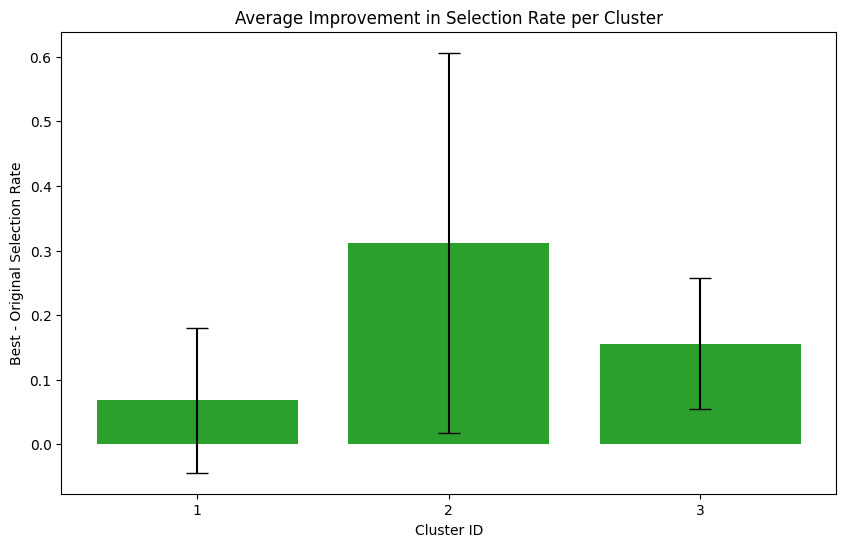

In [156]:
def safe_index(ls, item):
    try:
        return ls.index(item)
    except ValueError:
        return None

def plot_file(file_path):
    df = pd.read_json(file_path, lines=True)
    target_tool = df['target_tool_index'][0]
    cluster_id = df['cluster_id'][0]
    print(target_tool)
    # find index of first called tool
    df['called_tool_index'] = df.apply(
        lambda row: safe_index(list(map(lambda x: x['function']['name'], row['tools_provided'])), row['called_tool_names'][0]),
        axis=1
    )

    # Get total number of unique attempts
    num_attempts = df['attempt'].nunique()
    num_rows = (num_attempts + 4) // 5  # Round up division to determine number of rows needed

    # Create a grid with enough subplots for all attempts
    fig, axes = plt.subplots(num_rows, 5, figsize=(24, 5*num_rows), sharey=True)
    axes = axes.flatten()

    # Plot each attempt
    for i, attempt_number in enumerate(sorted(df['attempt'].unique())):
        plot_called_tool_index_distribution(df, attempt_number, ax=axes[i])

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f'Qwen3 Distribution of Index of Called Tool for Cluster {cluster_id}; file: {file_path}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def get_differential(file_path):
    df = pd.read_json(file_path, lines=True)
    # Group by 'attempt' and compute the mean of 'target_tool_selected'
    mean_selected = df.groupby('attempt')['target_tool_selected'].mean()
    return mean_selected



best_minus_original_per_cluster = []

model = 'qwen3'
n_clust = 3
for cluster_id in range(1, n_clust + 1):
    diffs_list = []
    for file in sorted(os.listdir(f'vllm/{model}')):
        if f'cluster-{cluster_id}-' in file and not file.endswith('improvement_history.jsonl'):
            diffs = get_differential(f'vllm/{model}/{file}')
            origin = diffs.iloc[0]
            best = diffs.max()
            diffs_list.append(best - origin)
    if diffs_list:
        best_minus_original_per_cluster.append(diffs_list)

# Compute mean and std error for each cluster
means = [np.nanmean(vals) for vals in best_minus_original_per_cluster]
stds = [np.std(vals) if len(vals) > 0 else 0 for vals in best_minus_original_per_cluster]

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(1, n_clust + 1)
ax.bar(x, means, yerr=stds, capsize=8, color='#2ca02c')
ax.set_xlabel('Cluster ID')
ax.set_ylabel('Best - Original Selection Rate')
ax.set_title('Average Improvement in Selection Rate per Cluster')
ax.set_xticks(x)
plt.show()

